In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# columns = ['image', 'label']
# train_df = pd.read_csv('data/labels/train_info.csv', names=columns, header=None)
# val_df = pd.read_csv('data/labels/val_info.csv', names=columns, header=None)

# count_columns = 'class,count'

# label_counts_train = train_df['label'].value_counts()
# label_counts_train.to_csv('data/labels/train_counts.csv', header=count_columns)
# label_counts_val = val_df['label'].value_counts()
# label_counts_val.to_csv('data/labels/val_counts.csv', header=count_columns)

In [3]:
counts_path = os.path.join('data', 'counts')
train_counts_df = pd.read_csv(os.path.join(counts_path, 'train_counts.csv'))
val_counts_df = pd.read_csv(os.path.join(counts_path, 'val_counts.csv'))

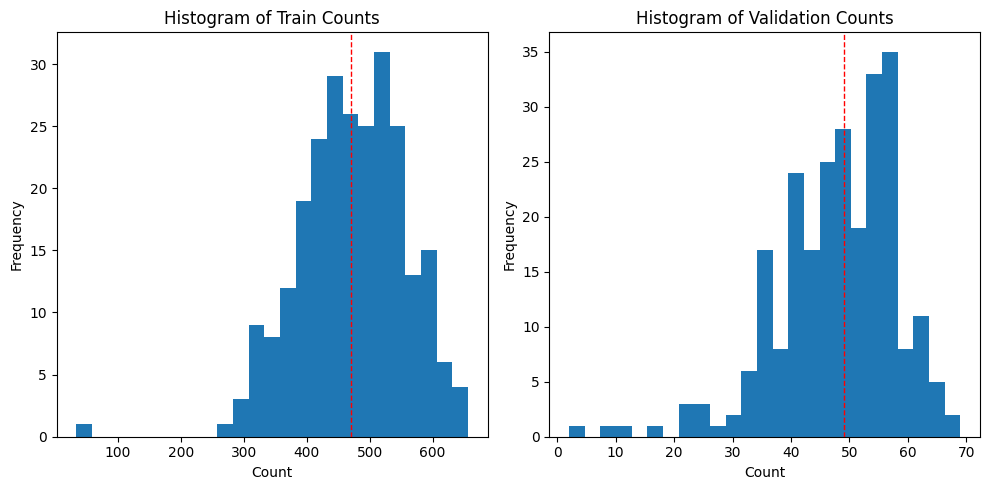

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


# Plot histogram for train counts
train_counts_df['count'].plot(kind='hist', bins=25, ax=axes[0], title='Histogram of Train Counts')
axes[0].axvline(train_counts_df['count'].median(), color='r', linestyle='dashed', linewidth=1)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Frequency')

# Plot histogram for validation counts
val_counts_df['count'].plot(kind='hist', bins=25, ax=axes[1], title='Histogram of Validation Counts')
axes[1].axvline(val_counts_df['count'].median(), color='r', linestyle='dashed', linewidth=1)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [5]:
max_count = train_counts_df['count'].max()
train_augments = pd.DataFrame(columns=['label', 'count'])
for index, row in train_counts_df.iterrows():
    label = row['label']
    count = row['count']
    train_augments.loc[index] = {'label': label, 'count': max_count - count}

train_augments.to_csv(os.path.join(counts_path, 'train_augments.csv'), index=False)

In [6]:
max_count = val_counts_df['count'].max()
val_augments = pd.DataFrame(columns=['label', 'count'])
for index, row in val_counts_df.iterrows():
    label = row['label']
    count = row['count']
    val_augments.loc[index] = {'label': label, 'count': max_count - count}

val_augments.to_csv(os.path.join(counts_path, 'val_augments.csv'), index=False)

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the transformation pipeline
train_transforms = A.Compose([
    # Randomly crop and resize to 256x256
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=1.0),
    
    # Horizontal Flip
    A.HorizontalFlip(p=0.5),
    
    # Random brightness and contrast
    A.RandomBrightnessContrast(p=0.2),

    A.HueSaturationValue(p=0.2),  # Randomly change hue, saturation, and value

    A.RandomGamma(p=0.2),  # Randomly change gamma
    
    # Normalize using ImageNet mean and std
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    
    # Convert image to a PyTorch tensor
    ToTensorV2(),
])

valtest_transforms = A.Compose([
    # Resize to 256x256
    A.Resize(height=256, width=256),
    
    # Normalize using ImageNet mean and std
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    
    # Convert image to a PyTorch tensor
    ToTensorV2(),
])

/home/andrea/Documents/unimib/.venv_3_12_4/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FoodNet(nn.Module):
    def __init__(self, num_classes=251):
        super(FoodNet, self).__init__()
        
        # Initial Conv Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Depthwise Separable Convolutions
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, groups=32)  # Depthwise
        self.conv2_pointwise = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1)  # Pointwise
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64)  # Depthwise
        self.conv3_pointwise = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)  # Pointwise
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, groups=128)  # Depthwise
        self.conv4_pointwise = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1)  # Pointwise
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, groups=256)  # Depthwise
        self.conv5_pointwise = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1)  # Pointwise
        self.bn5 = nn.BatchNorm2d(512)
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layer
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Initial Conv Layer
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Depthwise Separable Convolutions
        x = F.relu(self.bn2(self.conv2_pointwise(F.relu(self.conv2(x)))))
        x = F.relu(self.bn3(self.conv3_pointwise(F.relu(self.conv3(x)))))
        x = F.relu(self.bn4(self.conv4_pointwise(F.relu(self.conv4(x)))))
        x = F.relu(self.bn5(self.conv5_pointwise(F.relu(self.conv5(x)))))
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layer
        x = self.fc(x)
        
        return x


In [9]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

batch_size = 1

# Example: calculate the loss for a batch
# Assume outputs is your network's prediction (logits), and targets are the true labels
outputs = torch.randn(batch_size, 251)  # Replace with your model outputs
targets = torch.randint(0, 251, (batch_size,))  # Replace with your actual labels

# Calculate the loss
loss = criterion(outputs, targets)

In [17]:
from torchsummary import summary

model = FoodNet(num_classes=251)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

summary(model, (3, 256, 256), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
            Conv2d-3         [-1, 32, 256, 256]             320
            Conv2d-4         [-1, 64, 256, 256]           2,112
       BatchNorm2d-5         [-1, 64, 256, 256]             128
            Conv2d-6         [-1, 64, 256, 256]             640
            Conv2d-7        [-1, 128, 256, 256]           8,320
       BatchNorm2d-8        [-1, 128, 256, 256]             256
            Conv2d-9        [-1, 128, 256, 256]           1,280
           Conv2d-10        [-1, 256, 256, 256]          33,024
      BatchNorm2d-11        [-1, 256, 256, 256]             512
           Conv2d-12        [-1, 256, 256, 256]           2,560
           Conv2d-13        [-1, 512, 256, 256]         131,584
      BatchNorm2d-14        [-1, 512, 2

In [21]:
torch.onnx.export(model, torch.randn(1, 3, 256, 256).to(device), 'models/foodnet.onnx', input_names=['image'], output_names=['label'], verbose=False)